# ASIF - Code

In [2]:
from typing import Tuple, List, Type, Union
import torch
from tqdm import tqdm


def relative_represent(y: torch.Tensor, basis: torch.Tensor, non_zeros: int = 800, max_gpu_mem_gb: int = 8) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Compute the sparse decomposition of a tensor y with respect to a basis, 
    considering the available GPU memory.
    
    Args:
        y (torch.Tensor): Vectors to represent.
        basis (torch.Tensor): Basis to represent with respect to.
        non_zeros (int): Nonzero entries in the relative representation.
        max_gpu_mem_gb (int): Maximum GPU memory allowed to use in gigabytes.
        
    Returns:
        indices (torch.Tensor): Indices of the nonzero entries in each relative representation of y.
        values (torch.Tensor): Corresponding coefficients of the entries.
    """
    values, indices = torch.zeros((y.shape[0], non_zeros)), torch.zeros((y.shape[0], non_zeros), dtype=torch.long)

    free_gpu_mem = max_gpu_mem_gb * 1024 ** 3
    max_floats_in_mem = free_gpu_mem / 4
    max_chunk_y = max_floats_in_mem / basis.shape[0]
    n_chunks = int(y.shape[0] / max_chunk_y) + 1  
    chunk_y = int(y.shape[0] / n_chunks) + n_chunks

    with torch.no_grad():
        for c in range(n_chunks):
            in_prods = torch.einsum('ik, jk -> ij', y[c * chunk_y : (c + 1) * chunk_y], basis)
            values[c * chunk_y : (c + 1) * chunk_y], indices[c * chunk_y : (c + 1) * chunk_y] = torch.topk(in_prods, non_zeros, dim=1)
            del in_prods

    return indices.to('cpu'), values.to('cpu')


def sparsify(i: torch.Tensor, v: torch.Tensor, size: torch.Size) -> torch.sparse.FloatTensor:
    """
    Organize indices and values of n vectors into a single sparse tensor.

    Args:
        i (torch.Tensor): indices of non-zero elements of every vector. Shape: (n_vectors, nonzero elements)
        v (torch.Tensor): values of non-zero elements of every vector. Shape: (n_vectors, nonzero elements)
        size (torch.Size): shape of the output tensor

    Returns:
        torch.sparse.FloatTensor: sparse tensor of shape "size" (n_vectors, zero + nonzero elements)
    """
    flat_dim = len(i.flatten())
    coo_first_row_idxs = torch.div(torch.arange(flat_dim), i.shape[1], rounding_mode='floor')
    stacked_idxs = torch.cat((coo_first_row_idxs.unsqueeze(0), i.flatten().unsqueeze(0)), 0)
    return torch.sparse_coo_tensor(stacked_idxs, v.flatten(), size)


def normalize_sparse(tensor: torch.sparse.FloatTensor, nnz_per_row: int) -> torch.sparse.FloatTensor:
    """
    Normalize a sparse tensor by row.

    Args:
        tensor (torch.sparse.FloatTensor): The sparse tensor to normalize.
        nnz_per_row (int): The number of non-zero elements per row.

    Returns:
        torch.sparse.FloatTensor: The normalized sparse tensor.
    """
    norms = torch.sparse.sum(tensor * tensor, dim=1).to_dense()
    v = tensor._values().clone().detach().reshape(-1, nnz_per_row).t()
    v /= torch.sqrt(norms)
    return torch.sparse_coo_tensor(tensor._indices(), v.t().flatten(), tensor.shape)


def zero_shot_classification(zimgs: torch.Tensor, ztxts: torch.Tensor, aimgs: torch.Tensor, atxts: torch.Tensor, non_zeros: int, range_anch: range, val_exps: list, dic_size: int = 100_000, max_gpu_mem_gb: float = 8.) -> (list, dict, torch.Tensor):
    """
    Computes the zero-shot classification accuracy using relative representations
    over sets of anchors of different sizes and raising the similarities to the given exponents.
    
    Args:
        zimgs (torch.Tensor): absolute embeddings of the images
        ztxts (torch.Tensor): absolute embeddings of the texts
        aimgs (torch.Tensor): absolute embeddings of the anchor images
        atxts (torch.Tensor): absolute embeddings of the anchor texts
        test_labels (list): ground truth labels of the images
        non_zeros (int): nonzero entries in the relative representation (k in paper)
        range_anch (range): range of sizes of the anchor's sets to use (overshoot is ok)
        dic_size (int): size of the chunk of aimgs to load in memory to fit all intermediate variables in RAM
        val_exps (list): similarity exponents to test

    Returns:
        n_anchors (list): list of sizes of the anchor's sets (with overshooting fixed)
        scores (dict): dictionary of scores for each tested similarity exponent
        sims (torch.Tensor): similarity matrix between images and texts
    """
    n_anchors = []
    #scores = {ve: [] for ve in val_exps}
    #n_templates = max(int(ztxts.shape[0] / (max(test_labels) - min(test_labels) + 1)), 1)

    for i in tqdm(range_anch, position=0, leave=True):
        sims = torch.zeros((len(zimgs), len(ztxts)))
        idxs_imgs = torch.zeros(((len(zimgs), non_zeros * 2)), dtype=torch.long)
        idxs_txts = torch.zeros(((len(ztxts), non_zeros * 2)), dtype=torch.long)
        vals_imgs = torch.zeros(((len(zimgs), non_zeros * 2)))
        vals_txts = torch.zeros(((len(ztxts), non_zeros * 2)))

        for d in range(min(len(aimgs), i) // (dic_size + 1) + 1):
            idxs, values = relative_represent(zimgs, aimgs[d * dic_size : min(i, (d + 1) * dic_size)], non_zeros=non_zeros, max_gpu_mem_gb=max_gpu_mem_gb)
            idxs_imgs[:, :non_zeros] = idxs + d * dic_size
            vals_imgs[:, :non_zeros] = values
            idxs, values = relative_represent(ztxts, atxts[d * dic_size : min(i, (d + 1) * dic_size)], non_zeros=non_zeros, max_gpu_mem_gb=max_gpu_mem_gb)
            idxs_txts[:, :non_zeros] = idxs + d * dic_size
            vals_txts[:, :non_zeros] = values

            top_valsi, indices = torch.topk(vals_imgs, non_zeros, dim=1)
            top_idxsi = torch.gather(idxs_imgs, 1, indices)
            top_valst, indices = torch.topk(vals_txts, non_zeros, dim=1)
            top_idxst = torch.gather(idxs_txts, 1, indices)

            idxs_imgs[:, non_zeros:] = top_idxsi
            vals_imgs[:, non_zeros:] = top_valsi
            idxs_txts[:, non_zeros:] = top_idxst
            vals_txts[:, non_zeros:] = top_valst

        for val_exp in val_exps:
            ztxts_t = sparsify(top_idxst, top_valst ** val_exp, (len(ztxts), min(len(aimgs), i))).to(zimgs.device)
            ztxts_t = normalize_sparse(ztxts_t, non_zeros)

            if i < max_gpu_mem_gb * 1024 ** 3 / 4 / zimgs.shape[0]:  # einsum until it fits in GPU memory
                zimgs_t = sparsify(top_idxsi, top_valsi ** val_exp, (len(zimgs), min(len(aimgs), i))).to(zimgs.device)
                sims = torch.einsum('ij, kj -> ik', zimgs_t.to_dense(), ztxts_t.to_dense()).to('cpu')
            else:
                n_chunks = 6
                zs = zimgs.shape[0]
                chunks = [c * (zs // n_chunks) for c in range(n_chunks)] + [zs]
                for ci in range(n_chunks):
                    zimgs_t = sparsify(top_idxsi[chunks[ci]:chunks[ci+1]], top_valsi[chunks[ci]:chunks[ci+1]] ** val_exp, (chunks[ci+1] - chunks[ci], min(len(aimgs), i))).to(zimgs.device)
                    sims[chunks[ci]:chunks[ci+1]] = torch.sparse.mm(zimgs_t, ztxts_t.t()).to('cpu').to_dense()
            #score = float((torch.div(sims.argmax(axis=1),  n_templates, rounding_mode='floor') == torch.tensor(test_labels)).sum() / len(zimgs))
            #scores[val_exp].append(score)
        n_anchors.append(min(len(aimgs), i))
    return n_anchors, sims, zimgs_t, ztxts_t


def rand_mul_indices(indices_list: List[int], n_templates: int) -> torch.Tensor:
    """Returns a tensor containing randomly generated indices, based on the input indices_list and n_templates.

    Args:
        indices_list (List[int]): A list of integers representing the starting indices.
        n_templates (int): An integer representing the number of templates.

    Returns:
        torch.Tensor: A tensor containing randomly generated indices.
    """
    x = torch.randint(low=0, high=len(n_templates), size=(len(indices_list),))
    return torch.tensor(indices_list) * len(n_templates) + x


# Make retrieval

In [3]:
import json 
import numpy as np
import torch

with open('embeddings_layer6_wav2vec2.json', 'r') as f:
    audio = np.array(json.load(f))

with open('embeddings_layer3_bert-base-uncased.json', 'r') as f:
    nlp = np.array(json.load(f))

with open('../words_in_order1.json', 'r') as f:
    keys = json.load(f)    

In [4]:
all_values = [value for values_list in keys.values() for value in values_list]
n = audio.shape[0]
np.random.seed(2211) 
rows_to_delete = np.random.choice(n, int(n*0.15), replace=False) # Eliminamos el 10% de las filas para retrieval
deleted_rows = audio[rows_to_delete]  # Guardamos los indices de las filas eliminadas
audio_new = np.delete(audio, rows_to_delete, axis=0)
nlp_new = np.delete(nlp, rows_to_delete, axis=0)
keys_new = np.delete(all_values, rows_to_delete)

In [5]:
keys_test = [all_values[i] for i in rows_to_delete]

In [6]:
audio_new = torch.from_numpy(audio_new)
nlp_new = torch.from_numpy(nlp_new)
to_predict = torch.from_numpy(deleted_rows)

In [8]:
total_anchors = len(audio_new)  # Assuming aimgs and atxts are the same length
range_anch = range(total_anchors, total_anchors + 1)

n_anchors, sims, zimgs, ztxt = zero_shot_classification(to_predict, nlp_new, audio_new, nlp_new, non_zeros=6000, range_anch = range_anch, val_exps=[1], dic_size = 100_000, max_gpu_mem_gb = 8.)

100%|██████████| 1/1 [00:49<00:00, 49.14s/it]


# Test de retrieval

Select a number i from 0 to 4600

In [13]:
keys_test[4567]

'springs'

In [12]:
# Assuming words_list is a list where the index corresponds to the words
# For example: words_list = ['hello', 'world', ..., 'example']

# Extract words using the indices in keys_new
words_for_plot = [keys_new[i] for i in zimgs[4567].coalesce().indices()[0].numpy()]
words_for_plot

['classes',
 'and',
 'christmas',
 'its',
 'mind',
 'results',
 'season',
 'the',
 'year',
 'frederick',
 'grave',
 'is',
 'really',
 'sir',
 'whether',
 'work',
 'bath',
 'flash',
 'his',
 'same',
 'says',
 'smile',
 'teeth',
 'the',
 'to',
 'turkish',
 'expression',
 'lucidity',
 'art',
 'in',
 'is',
 'us',
 'foreign',
 'and',
 'furnishing',
 'of',
 'upholsterer',
 'us',
 'fire',
 'for',
 'grace',
 'man',
 'recognising',
 'should',
 'that',
 'work',
 'chance',
 'painting',
 'conquering',
 'instead',
 'of',
 'sits',
 'sleeping',
 'interest',
 'squeeze',
 'to',
 'with',
 'be',
 'because',
 'one',
 'you',
 'so',
 'go',
 'and',
 'dominions',
 'nomes',
 'shaggy',
 'dominions',
 'kaliko',
 'secret',
 'do',
 'summons',
 'used',
 'at',
 'often',
 'thrown',
 'exist',
 'sir',
 'chest',
 'eyes',
 'his',
 'spectators',
 'thousands',
 'chest',
 'his',
 'said',
 'time',
 'rate',
 'as',
 'death',
 'doors',
 'night',
 'so',
 'this',
 'urgency',
 'and',
 'see',
 'his',
 'then',
 'muscles',
 'fencing'

In [31]:
zimgs[4567].indices()

RuntimeError: Cannot get indices on an uncoalesced tensor, please call .coalesce() first

In [27]:
# Word to test if the retrieval works
keys_test[457]

'start'

In [28]:
# Looking at the result
values, indices = torch.topk(sims[457], k=6)
indices

tensor([29625, 21534,  3895,  6881,  5389, 23873])

In [29]:
# Checking the first or another retrieval
keys_new[indices[0]]

'haul'

In [33]:
# Use these indices to select the relevant part of your audio data
selected_audio = audio_new[zimgs[4567].coalesce().indices()[0]]
selected_audio_np = selected_audio.numpy()


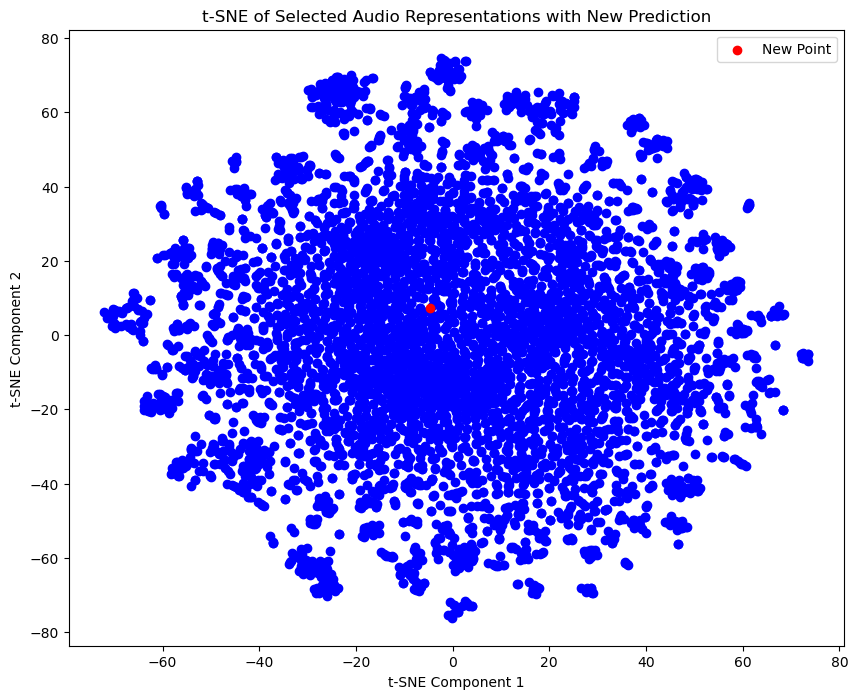

In [35]:

import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Adding to_predict[4567] to the existing numpy array
new_point = to_predict[4567].numpy()  # Assuming to_predict[4567] is a tensor
all_audio = np.vstack([selected_audio_np, new_point])

# Initialize t-SNE with 2 components
tsne = TSNE(n_components=2, random_state=42)

# Run t-SNE on the new dataset
transformed_audio = tsne.fit_transform(all_audio)

# Now, transformed_audio includes the t-SNE output for the original data plus the new point
# Assuming you have 'words_for_plot' from previous steps for the existing points
# Including a label for the new point
words_for_plot.append('New Point')

# Plotting the original points in blue
plt.figure(figsize=(10, 8))
scatter = plt.scatter(transformed_audio[:-1, 0], transformed_audio[:-1, 1], c='blue', marker='o')

# Plotting the new point in red
plt.scatter(transformed_audio[-1, 0], transformed_audio[-1, 1], c='red', marker='o', label='New Point')


plt.title('t-SNE of Selected Audio Representations with New Prediction')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()
